In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../lib")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import temporal_encoder_common
from temporal_encoder_common import Filters
import nonneg_common
import lif_utils
import nengo
import dlop_ldn_function_bases as bases

In [28]:
n_neurons = 200
n_temporal_dimensions = 3
n_dimensions = 2

def mk_encs(n, d, rng=np.random):
    encs = rng.normal(0, 1, (n, d))
    encs /= np.linalg.norm(encs, axis=1)[:, None]
    return encs

def mk_matrix_encoders(n, d, q, rng=np.random):
    encs = mk_encs(n, d * q, rng)
    return encs.reshape(n, d, q)

gains, biases, _ = nonneg_common.mk_ensemble(n_neurons, d=1)
G = lif_utils.lif_rate
TEs = mk_encs(n_neurons, n_temporal_dimensions)
Es = mk_encs(n_neurons, n_dimensions)
#MEs = np.einsum('Nd,Nq->Ndq', Es, TEs)
MEs = mk_matrix_encoders(n_neurons, n_dimensions, n_temporal_dimensions)

A, B = bases.mk_ldn_lti(n_temporal_dimensions)

T, dt = 10.0, 1e-3
ts = np.arange(0, T, dt)
Ms = temporal_encoder_common.cached_lti_impulse_response(A, B, ts)

flts_in = [(100e-3,),]
flts_rec = [(100e-3,),]

In [31]:
np.random.seed(58381)
W_in, W_rec, errs = temporal_encoder_common.solve_for_recurrent_population_weights_with_spatial_encoder(
    G, gains, biases, None, None, TEs, Es,
    [Filters.lowpass(*flt_in) for flt_in in flts_in],
    [Filters.lowpass(*flt_rec) for flt_rec in flts_rec],
    Ms=Ms,
    N_smpls=1000,
    xs_sigma=3.0,
    biased=False,)

100%|██████████| 200/200 [00:06<00:00, 30.99it/s]


In [32]:
np.random.seed(58381)
W_in_me, W_rec_me, errs_me = temporal_encoder_common.solve_for_recurrent_population_weights_with_spatiotemporal_matrices(
    G, gains, biases, None, None, MEs,
    [Filters.lowpass(*flt_in) for flt_in in flts_in],
    [Filters.lowpass(*flt_rec) for flt_rec in flts_rec],
    Ms=Ms,
    N_smpls=1000,
    xs_sigma=3.0,
    biased=False,)

100%|██████████| 200/200 [00:06<00:00, 31.77it/s]


In [33]:
np.sqrt(np.mean(np.square(errs))), np.sqrt(np.mean(np.square(errs_me)))

(0.005964924425194699, 0.0051225156787911424)

In [18]:
np.random.seed(498184)

def execute_network(xs,
                    W_in,
                    W_rec,
                    gains,
                    biases,
                    T=100.0,
                    dt=1e-3,
                    tau=100e-3):
    N = int(T / dt + 1e-9)
    n_dims = n_dimensions
    n_neurons = len(gains)

    with nengo.Network() as model:
        nd_in = nengo.Node(size_in=n_dims)
        for i in range(n_dims):
#            def mk_sig(i=i):
#                return lambda t: xs[int(t / dt) % N, i]
#            nd_noise = nengo.Node(mk_sig())
            nd_noise = nengo.Node(nengo.processes.WhiteSignal(period=100.0, high=1.0, y0=0.0, rms=0.5))
            nengo.Connection(nd_noise, nd_in[i], synapse=None)

        ens_x = nengo.Ensemble(n_neurons=n_neurons,
                               dimensions=1,
                               bias=biases,
                               gain=gains,
                               encoders=np.ones((n_neurons, 1)))

        nengo.Connection(nd_in,
                         ens_x.neurons,
                         transform=W_in[:, :, 0],
                         synapse=tau)

        nengo.Connection(ens_x.neurons,
                         ens_x.neurons,
                         transform=W_rec[:, :, 0],
                         synapse=tau)

        p_in = nengo.Probe(nd_in, synapse=None)
        p_out = nengo.Probe(ens_x.neurons, synapse=None)

    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(T)

    return sim.data[p_in], sim.data[p_out]

xs_test, As_test = execute_network(None, W_in_me, W_rec_me, gains, biases)
xs_train, As_train = execute_network(None, W_in_me, W_rec_me, gains, biases)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [21]:
ts = np.arange(0, xs_train.shape[0]) * 1e-3

xs_train_flt = nengo.Lowpass(100e-3).filtfilt(xs_train)
As_train_flt = nengo.Lowpass(100e-3).filtfilt(As_train)

xs_test_flt = nengo.Lowpass(100e-3).filtfilt(xs_test)
As_test_flt = nengo.Lowpass(100e-3).filtfilt(As_test)

(0.0, 10.0)

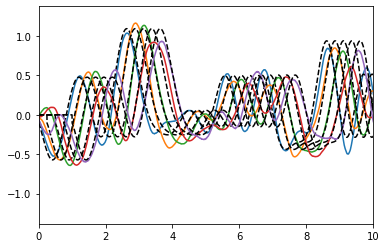

In [23]:
def shift(xs, t, dt=1e-3):
    N = xs.shape[0]
    N_shift = int(t / dt)
    return np.concatenate((np.zeros(N_shift), xs))[:N]

fig, ax = plt.subplots()

for theta in np.linspace(0, 1.0, 5):
    xs_train_flt_shift = shift(xs_train_flt[:, 0], theta)
    xs_test_flt_shift = shift(xs_test_flt[:, 0], theta)
    d1 = np.linalg.lstsq(As_train_flt, xs_train_flt_shift, rcond=1e-2)[0]

    ax.plot(ts, As_test_flt @ d1)
    ax.plot(ts, xs_test_flt_shift, 'k--')

ax.set_xlim(0, 10)

In [ ]:
d1 = np.linalg.lstsq(As_train_flt, xs_train_flt[:, 0], rcond=1e-2)[0]
d2 = np.linalg.lstsq(As_train_flt, xs_train_flt[:, 1], rcond=1e-2)[0]

In [ ]:
fig, ax = plt.subplots()
ax.plot(As_test_flt @ d1)
ax.plot(xs_test_flt[:, 0])
ax.set_xlim(0, 10000)

In [ ]:
fig, ax = plt.subplots()
ax.plot(As_test_flt @ d2)
ax.plot(xs_test_flt[:, 1])
ax.set_xlim(0, 10000)